<a href="https://colab.research.google.com/github/JReal10/Booking-application-/blob/master/butterfly_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow matplotlib opencv-python

In [2]:
import os, re, time, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

#deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# datasets

labels = pd.read_csv("/content/drive/MyDrive/archive/Training_set.csv")
sample = pd.read_csv('/content/drive/MyDrive/archive/Testing_set.csv')


# folders paths
train_path = "/content/drive/MyDrive/archive/train"
test_path = "/content/drive/MyDrive/archive/test"

In [5]:
labels.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


# Augmenting Data

It’s a pre-processing technique in which we augment the existing dataset with transformed versions of the existing images. We can perform scaling, rotations, increasing brightness, and other affine transformations.

Description of few of its parameters that are used below:

1. rescale: rescales values by the given factor
2. horizontal flip: randomly flip inputs horizontally.
3. validation_split: this is the fraction of images reserved for validation (between 0 and 1).

In [6]:
gen = ImageDataGenerator(rescale = 1./255.,
                         horizontal_flip = True,
                         validation_split = 0.2)
train_generator = gen.flow_from_dataframe(
    labels,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    subset = "training",
    color_mode = 'rgb',
    target_size = (331,331),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
)

validation_generator = gen.flow_from_dataframe(
    labels,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    subset = 'validation',
        color_mode = 'rgb',
    target_size = (331,331),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
)

Found 2741 validated image filenames belonging to 75 classes.
Found 685 validated image filenames belonging to 75 classes.


In [7]:
x,y = next(train_generator)
x.shape

(32, 331, 331, 3)

# Image Visualization

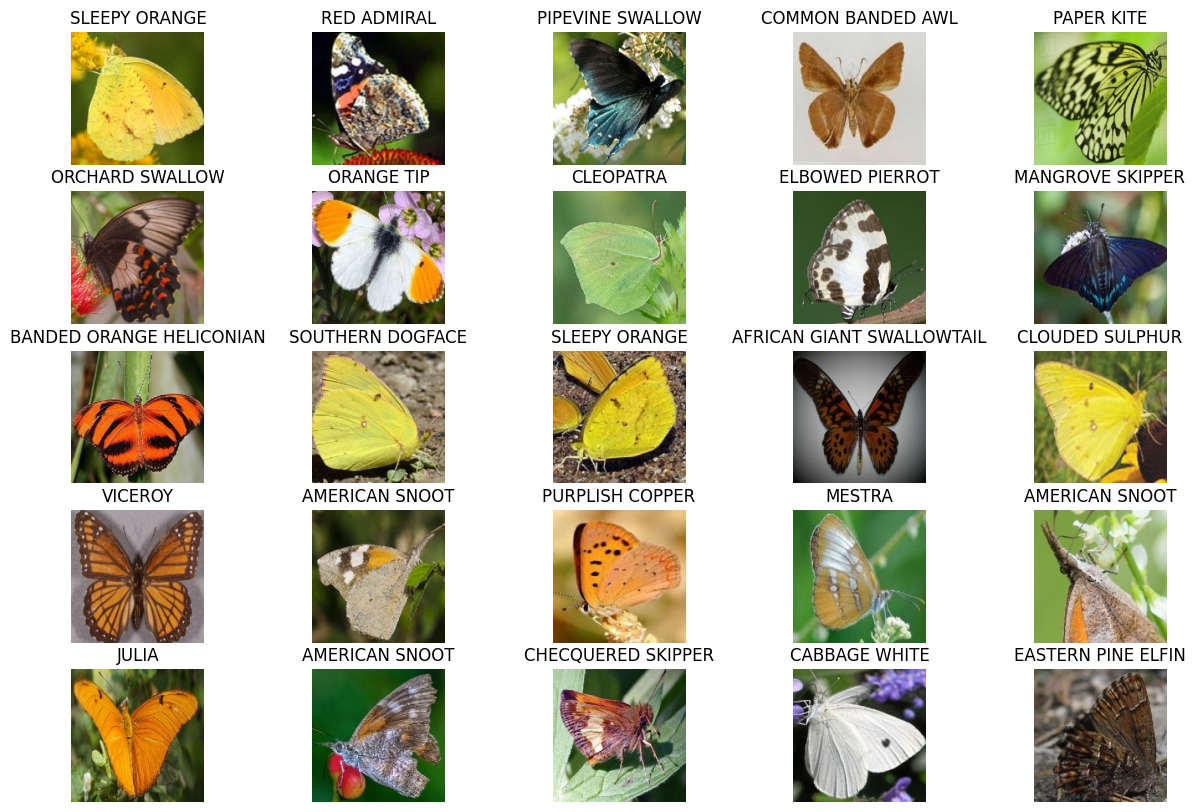

In [8]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [9]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(75, activation='softmax')
    ])

219055592/219055592 [==============================] - 1s 0us/step


# BatchNormalization :

1. It is a normalization technique which is done along mini-batches instead of the full data set.
2. It is used to speed up training and use higher learning rates.
3. It maintains the mean output close to 0 and the output standard deviation close to 1.

# GlobalAveragePooling2D :

1. It takes a tensor of size (input width) x (input height) x (input channels) and computes the average value of all values across the entire (input width) x (input height) matrix for each of the (input channels).
2. The dimensionality of the images is reduced by reducing the number of pixels in the output from the previous neural network layer.
3. By using this we get a 1-dimensional tensor of size (input channels) as our output.
4. 2D Global average pooling operation. Here ‘Depth’ = ‘Filters’

# Dense Layers:
These layers are regular fully connected neural network layers connected after the convolutional layers.

# Drop out layer:
is also used whose function is to randomly drop some neurons from the input unit so as to prevent overfitting. The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped.

In [10]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

# Defining callbacks to preserve the best results:

Callback: It is an object that can perform actions at various stages of training (for example, at the start or end of an epoch, before or after a single batch, etc).

In [12]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

# Training the model:
It means that we are finding a set of values for weights and biases that have a low loss on average across all the records.

In [13]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

Epoch 1/25
85/85 [==============================] - 1453s 17s/step - loss: 3.8088 - accuracy: 0.1004 - val_loss: 3.0452 - val_accuracy: 0.1875
Epoch 2/25
85/85 [==============================] - 47s 547ms/step - loss: 2.8752 - accuracy: 0.2381 - val_loss: 2.3328 - val_accuracy: 0.3080
Epoch 3/25
85/85 [==============================] - 43s 500ms/step - loss: 2.2452 - accuracy: 0.3702 - val_loss: 1.9271 - val_accuracy: 0.4524
Epoch 4/25
85/85 [==============================] - 44s 521ms/step - loss: 1.7928 - accuracy: 0.4743 - val_loss: 1.5743 - val_accuracy: 0.5372
Epoch 5/25
85/85 [==============================] - 44s 519ms/step - loss: 1.4915 - accuracy: 0.5541 - val_loss: 1.4494 - val_accuracy: 0.5967
Epoch 6/25
85/85 [==============================] - 43s 506ms/step - loss: 1.2156 - accuracy: 0.6238 - val_loss: 1.2741 - val_accuracy: 0.6101
Epoch 7/25
85/85 [==============================] - 45s 531ms/step - loss: 1.0466 - accuracy: 0.6615 - val_loss: 1.1308 - val_accuracy: 0.6592

In [14]:
model.save("ButterflyModel.h5")

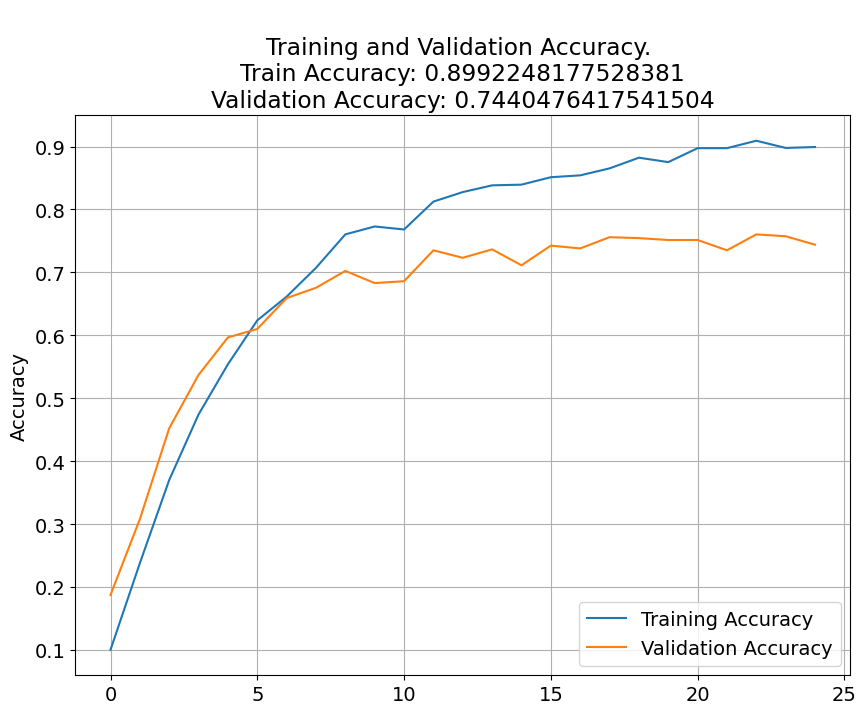

In [18]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

# Display the plot
plt.show()

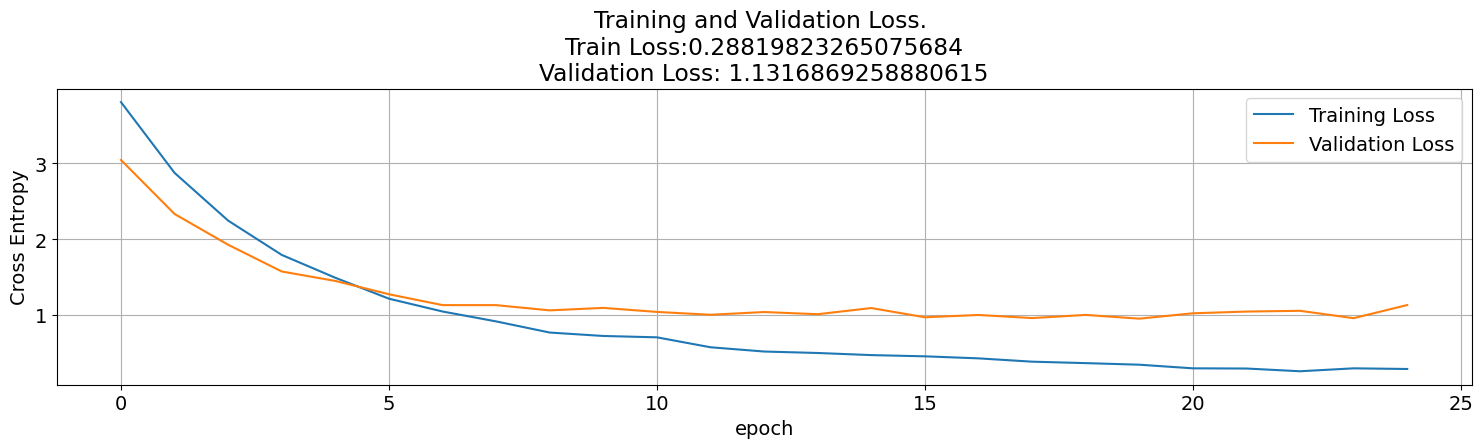

In [19]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [20]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

22/22 [==============================] - 14s 652ms/step - loss: 1.1156 - accuracy: 0.7445
[1.1155563592910767, 0.7445255517959595]
Accuracy: 74.4526%
Loss:  1.1155563592910767
